In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the dataset
df = pd.read_csv('../Dataset/archive/hypothyroid.csv')
print("Dataset Shape:", df.shape)
print("\nColumn Names:")
print(df.columns.tolist())
print("\nData Types:")
print(df.dtypes)
print("\nTarget Variable Distribution:")
print(df['binaryClass'].value_counts())

Dataset Shape: (3772, 30)

Column Names:
['age', 'sex', 'on thyroxine', 'query on thyroxine', 'on antithyroid medication', 'sick', 'pregnant', 'thyroid surgery', 'I131 treatment', 'query hypothyroid', 'query hyperthyroid', 'lithium', 'goitre', 'tumor', 'hypopituitary', 'psych', 'TSH measured', 'TSH', 'T3 measured', 'T3', 'TT4 measured', 'TT4', 'T4U measured', 'T4U', 'FTI measured', 'FTI', 'TBG measured', 'TBG', 'referral source', 'binaryClass']

Data Types:
age                          object
sex                          object
on thyroxine                 object
query on thyroxine           object
on antithyroid medication    object
sick                         object
pregnant                     object
thyroid surgery              object
I131 treatment               object
query hypothyroid            object
query hyperthyroid           object
lithium                      object
goitre                       object
tumor                        object
hypopituitary                objec

In [3]:
# Check for missing values
print("Missing Values:")
print(df.isnull().sum())
print("\nDataset Info:")
df.info()
print("\nDataset Description:")
print(df.describe())

Missing Values:
age                          0
sex                          0
on thyroxine                 0
query on thyroxine           0
on antithyroid medication    0
sick                         0
pregnant                     0
thyroid surgery              0
I131 treatment               0
query hypothyroid            0
query hyperthyroid           0
lithium                      0
goitre                       0
tumor                        0
hypopituitary                0
psych                        0
TSH measured                 0
TSH                          0
T3 measured                  0
T3                           0
TT4 measured                 0
TT4                          0
T4U measured                 0
T4U                          0
FTI measured                 0
FTI                          0
TBG measured                 0
TBG                          0
referral source              0
binaryClass                  0
dtype: int64

Dataset Info:
<class 'pandas.core.frame.

In [4]:
def preprocess_data(df, target_col):
    print("=" * 50)
    print("DATA PREPROCESSING")
    print("=" * 50)
    
    # Create a copy
    data = df.copy()
    
    # Separate features and target
    X = data.drop(target_col, axis=1)
    y = data[target_col]
    
    # Handle missing values
    print("Handling missing values...")
    for col in X.columns:
        if X[col].dtype == 'object':
            # For categorical: fill with mode
            if not X[col].mode().empty:
                X[col] = X[col].fillna(X[col].mode()[0])
            else:
                X[col] = X[col].fillna('unknown')
        else:
            # For numerical: fill with median
            X[col] = X[col].fillna(X[col].median())
    
    # Encode categorical variables
    print("Encoding categorical variables...")
    label_encoders = {}
    for col in X.columns:
        if X[col].dtype == 'object':
            le = LabelEncoder()
            X[col] = le.fit_transform(X[col].astype(str))
            label_encoders[col] = le
    
    # Encode target variable if it's categorical
    target_encoder = None
    if y.dtype == 'object':
        target_encoder = LabelEncoder()
        y = target_encoder.fit_transform(y)
    
    print(f"Preprocessed data shape: {X.shape}")
    print(f"Target classes: {np.unique(y)}")
    
    return X, y, label_encoders, target_encoder

# Get target column
target_col = df.columns[-1]
print(f"Target variable: {target_col}")
print(f"Target distribution:\n{df[target_col].value_counts()}")

# Preprocess data
X, y, encoders, target_encoder = preprocess_data(df, target_col)

Target variable: binaryClass
Target distribution:
binaryClass
P    3481
N     291
Name: count, dtype: int64
DATA PREPROCESSING
Handling missing values...
Encoding categorical variables...
Preprocessed data shape: (3772, 29)
Target classes: [0 1]


FEATURE ENGINEERING
Top 10 most important features:
            feature  importance
17              TSH    0.376251
25              FTI    0.115165
21              TT4    0.105452
19               T3    0.102946
0               age    0.075165
23              T4U    0.070884
16     TSH measured    0.031748
28  referral source    0.022977
2      on thyroxine    0.019695
1               sex    0.015647


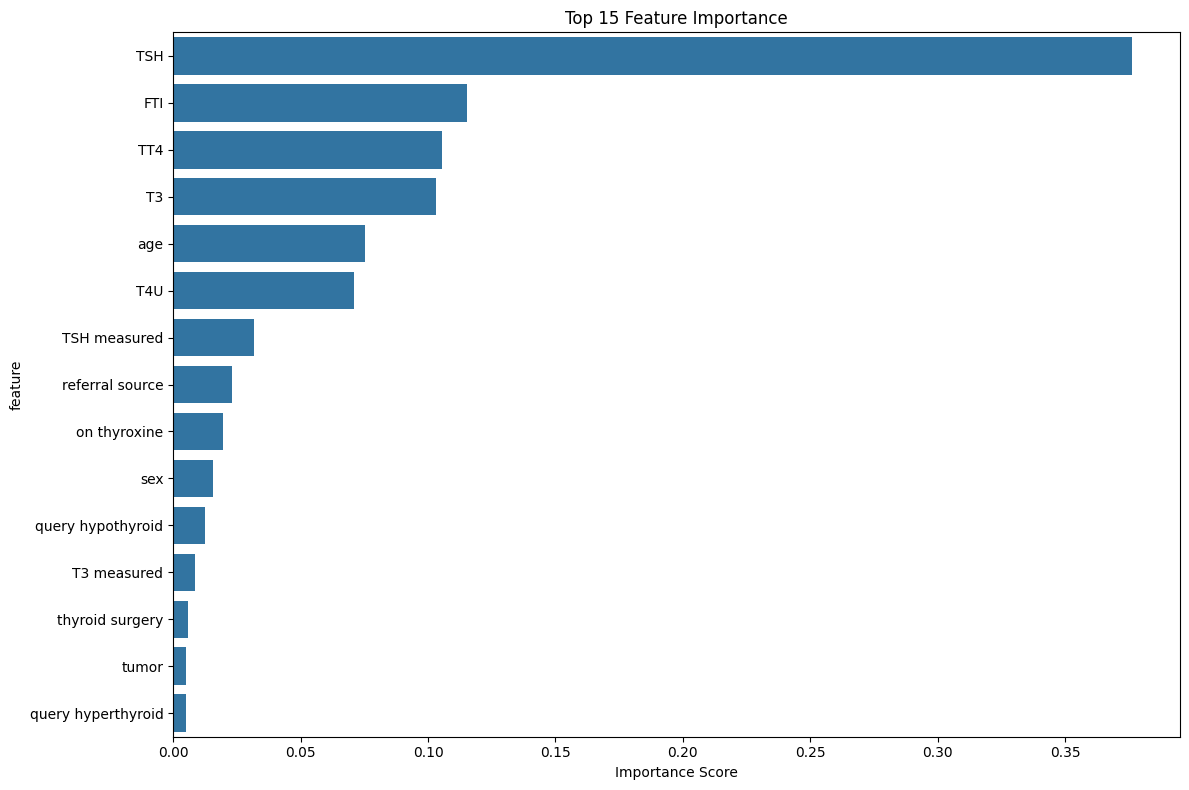

Selected 15 features out of 29


In [5]:
def feature_engineering(X, y):
    print("=" * 50)
    print("FEATURE ENGINEERING")
    print("=" * 50)
    
    # Feature importance using Random Forest
    rf_temp = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_temp.fit(X, y)
    
    # Get feature importance
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': rf_temp.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("Top 10 most important features:")
    print(feature_importance.head(10))
    
    # Visualize feature importance
    plt.figure(figsize=(12, 8))
    sns.barplot(data=feature_importance.head(15), x='importance', y='feature')
    plt.title('Top 15 Feature Importance')
    plt.xlabel('Importance Score')
    plt.tight_layout()
    plt.show()
    
    # Select top features (you can adjust this threshold)
    top_features = feature_importance.head(15)['feature'].tolist()
    X_selected = X[top_features]
    
    print(f"Selected {len(top_features)} features out of {len(X.columns)}")
    
    return X_selected, feature_importance

# Feature engineering
X_selected, feat_importance = feature_engineering(X, y)

In [6]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=42, stratify=y
)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set shape: {X_train_scaled.shape}")
print(f"Test set shape: {X_test_scaled.shape}")
print(f"Training set target distribution: {np.bincount(y_train)}")
print(f"Test set target distribution: {np.bincount(y_test)}")

Training set shape: (3017, 15)
Test set shape: (755, 15)
Training set target distribution: [ 233 2784]
Test set target distribution: [ 58 697]


In [7]:
def train_and_tune_models_complete(X_train, X_test, y_train, y_test):
    print("=" * 60)
    print("COMPLETE MODEL TRAINING AND TUNING")
    print("=" * 60)
    
    models = {}
    
    # 1. Random Forest with GridSearch
    print("Training Random Forest...")
    rf_params = {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['auto', 'sqrt', 'log2']
    }
    
    rf = RandomForestClassifier(random_state=42)
    rf_grid = GridSearchCV(rf, rf_params, cv=5, scoring='accuracy', n_jobs=-1)
    rf_grid.fit(X_train, y_train)
    models['Random Forest'] = rf_grid.best_estimator_
    print(f"Best RF params: {rf_grid.best_params_}")
    
    # 2. Decision Tree with GridSearch
    print("Training Decision Tree...")
    dt_params = {
        'criterion': ['gini', 'entropy'],
        'max_depth': [None, 5, 10, 15, 20],
        'min_samples_split': [2, 5, 10, 15],
        'min_samples_leaf': [1, 2, 5, 10],
        'max_features': ['auto', 'sqrt', 'log2', None]
    }
    
    dt = DecisionTreeClassifier(random_state=42)
    dt_grid = GridSearchCV(dt, dt_params, cv=5, scoring='accuracy', n_jobs=-1)
    dt_grid.fit(X_train, y_train)
    models['Decision Tree'] = dt_grid.best_estimator_
    print(f"Best DT params: {dt_grid.best_params_}")
    
    # 3. K-Nearest Neighbors with GridSearch
    print("Training K-Nearest Neighbors...")
    knn_params = {
        'n_neighbors': [3, 5, 7, 9, 11, 15, 21],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan', 'minkowski'],
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
        'p': [1, 2]  # p=1 for manhattan, p=2 for euclidean
    }
    
    knn = KNeighborsClassifier()
    knn_grid = GridSearchCV(knn, knn_params, cv=5, scoring='accuracy', n_jobs=-1)
    knn_grid.fit(X_train, y_train)
    models['K-Nearest Neighbors'] = knn_grid.best_estimator_
    print(f"Best KNN params: {knn_grid.best_params_}")
    
    # 4. Gradient Boosting
    print("Training Gradient Boosting...")
    gb_params = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.05, 0.1, 0.15, 0.2],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 0.9, 1.0]
    }
    
    gb = GradientBoostingClassifier(random_state=42)
    gb_grid = GridSearchCV(gb, gb_params, cv=5, scoring='accuracy', n_jobs=-1)
    gb_grid.fit(X_train, y_train)
    models['Gradient Boosting'] = gb_grid.best_estimator_
    print(f"Best GB params: {gb_grid.best_params_}")
    
    # 5. Logistic Regression
    print("Training Logistic Regression...")
    lr_params = {
        'C': [0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear'],
        'max_iter': [1000, 2000]
    }
    
    lr = LogisticRegression(random_state=42)
    lr_grid = GridSearchCV(lr, lr_params, cv=5, scoring='accuracy', n_jobs=-1)
    lr_grid.fit(X_train, y_train)
    models['Logistic Regression'] = lr_grid.best_estimator_
    print(f"Best LR params: {lr_grid.best_params_}")
    
    # 6. SVM
    print("Training SVM...")
    svm_params = {
        'C': [0.1, 1, 10, 100],
        'kernel': ['rbf', 'linear'],
        'gamma': ['scale', 'auto', 0.01, 0.1]
    }
    
    svm = SVC(random_state=42)
    svm_grid = GridSearchCV(svm, svm_params, cv=5, scoring='accuracy', n_jobs=-1)
    svm_grid.fit(X_train, y_train)
    models['SVM'] = svm_grid.best_estimator_
    print(f"Best SVM params: {svm_grid.best_params_}")
    
    return models

# Train all models
trained_models = train_and_tune_models_complete(X_train_scaled, X_test_scaled, y_train, y_test)

COMPLETE MODEL TRAINING AND TUNING
Training Random Forest...
Best RF params: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Training Decision Tree...
Best DT params: {'criterion': 'entropy', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 15}
Training K-Nearest Neighbors...
Best KNN params: {'algorithm': 'auto', 'metric': 'manhattan', 'n_neighbors': 5, 'p': 1, 'weights': 'distance'}
Training Gradient Boosting...
Best GB params: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Training Logistic Regression...
Best LR params: {'C': 0.1, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'liblinear'}
Training SVM...
Best SVM params: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}


COMPLETE MODEL EVALUATION

Random Forest:
  Cross-validation: 0.9669 (+/- 0.0066)
  Train Accuracy: 1.0000
  Test Accuracy: 0.9656

Detailed Report for Random Forest:
              precision    recall  f1-score   support

           0       0.90      0.62      0.73        58
           1       0.97      0.99      0.98       697

    accuracy                           0.97       755
   macro avg       0.93      0.81      0.86       755
weighted avg       0.96      0.97      0.96       755



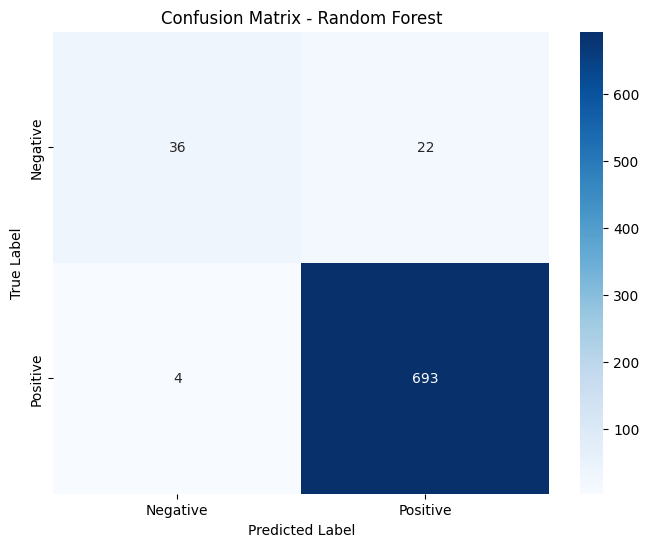


Decision Tree:
  Cross-validation: 0.9877 (+/- 0.0068)
  Train Accuracy: 0.9937
  Test Accuracy: 0.9934

Detailed Report for Decision Tree:
              precision    recall  f1-score   support

           0       0.98      0.93      0.96        58
           1       0.99      1.00      1.00       697

    accuracy                           0.99       755
   macro avg       0.99      0.96      0.98       755
weighted avg       0.99      0.99      0.99       755



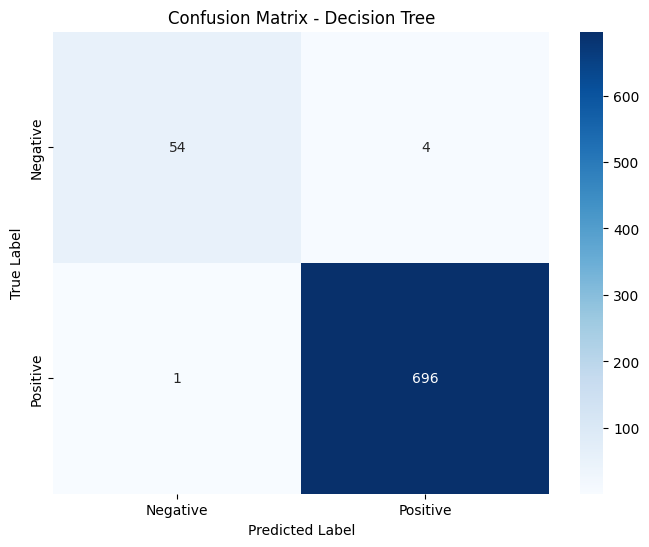


K-Nearest Neighbors:
  Cross-validation: 0.9380 (+/- 0.0033)
  Train Accuracy: 1.0000
  Test Accuracy: 0.9298

Detailed Report for K-Nearest Neighbors:
              precision    recall  f1-score   support

           0       0.62      0.22      0.33        58
           1       0.94      0.99      0.96       697

    accuracy                           0.93       755
   macro avg       0.78      0.61      0.65       755
weighted avg       0.91      0.93      0.91       755



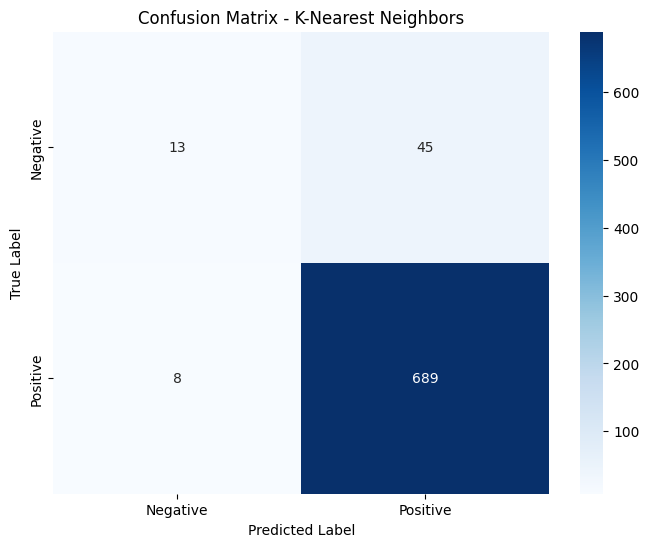


Gradient Boosting:
  Cross-validation: 0.9920 (+/- 0.0039)
  Train Accuracy: 1.0000
  Test Accuracy: 0.9947

Logistic Regression:
  Cross-validation: 0.9423 (+/- 0.0043)
  Train Accuracy: 0.9443
  Test Accuracy: 0.9444

SVM:
  Cross-validation: 0.9446 (+/- 0.0077)
  Train Accuracy: 0.9639
  Test Accuracy: 0.9457

SUMMARY OF ALL MODELS
                     CV Mean  CV Std  Train Accuracy  Test Accuracy
Random Forest         0.9669  0.0033          1.0000         0.9656
Decision Tree         0.9877  0.0034          0.9937         0.9934
K-Nearest Neighbors   0.9380  0.0016          1.0000         0.9298
Gradient Boosting     0.9920  0.0019          1.0000         0.9947
Logistic Regression   0.9423  0.0022          0.9443         0.9444
SVM                   0.9446  0.0039          0.9639         0.9457

Best Model: Gradient Boosting
Best Test Accuracy: 0.9947


In [8]:
def evaluate_models_complete(models, X_train, X_test, y_train, y_test):
    print("=" * 60)
    print("COMPLETE MODEL EVALUATION")
    print("=" * 60)
    
    results = {}
    
    for name, model in models.items():
        # Cross-validation score
        cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
        
        # Train and test predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        
        # Calculate accuracies
        train_accuracy = accuracy_score(y_train, y_train_pred)
        test_accuracy = accuracy_score(y_test, y_test_pred)
        
        results[name] = {
            'CV Mean': cv_scores.mean(),
            'CV Std': cv_scores.std(),
            'Train Accuracy': train_accuracy,
            'Test Accuracy': test_accuracy
        }
        
        print(f"\n{name}:")
        print(f"  Cross-validation: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
        print(f"  Train Accuracy: {train_accuracy:.4f}")
        print(f"  Test Accuracy: {test_accuracy:.4f}")
        
        # Detailed classification report for tree-based models and KNN
        if name in ['Random Forest', 'Decision Tree', 'K-Nearest Neighbors']:
            print(f"\nDetailed Report for {name}:")
            print(classification_report(y_test, y_test_pred))
            
            # Confusion Matrix
            plt.figure(figsize=(8, 6))
            cm = confusion_matrix(y_test, y_test_pred)
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                       xticklabels=['Negative', 'Positive'], 
                       yticklabels=['Negative', 'Positive'])
            plt.title(f'Confusion Matrix - {name}')
            plt.ylabel('True Label')
            plt.xlabel('Predicted Label')
            plt.show()
    
    # Create results DataFrame
    results_df = pd.DataFrame(results).T
    print("\n" + "="*60)
    print("SUMMARY OF ALL MODELS")
    print("="*60)
    print(results_df.round(4))
    
    # Find best model
    best_model_name = results_df['Test Accuracy'].idxmax()
    best_accuracy = results_df.loc[best_model_name, 'Test Accuracy']
    
    print(f"\nBest Model: {best_model_name}")
    print(f"Best Test Accuracy: {best_accuracy:.4f}")
    
    return results_df, models[best_model_name]

# Evaluate all models
results_summary, best_model = evaluate_models_complete(trained_models, X_train_scaled, X_test_scaled, y_train, y_test)

FEATURE IMPORTANCE ANALYSIS

Top 10 features for Decision Tree:
            feature  importance
0               TSH    0.845495
8      on thyroxine    0.078749
12  thyroid surgery    0.023637
3                T3    0.015673
5               T4U    0.014656
4               age    0.010285
1               FTI    0.007459
7   referral source    0.004044
2               TT4    0.000000
6      TSH measured    0.000000

Top 10 features for Random Forest:
           feature  importance
0              TSH    0.385194
1              FTI    0.117671
2              TT4    0.110104
3               T3    0.109308
4              age    0.079618
5              T4U    0.073753
6     TSH measured    0.029053
8     on thyroxine    0.022224
7  referral source    0.020052
9              sex    0.018462

Top 10 features for Gradient Boosting:
              feature  importance
0                 TSH    0.684485
6        TSH measured    0.098092
8        on thyroxine    0.084267
3                  T3    0.0379

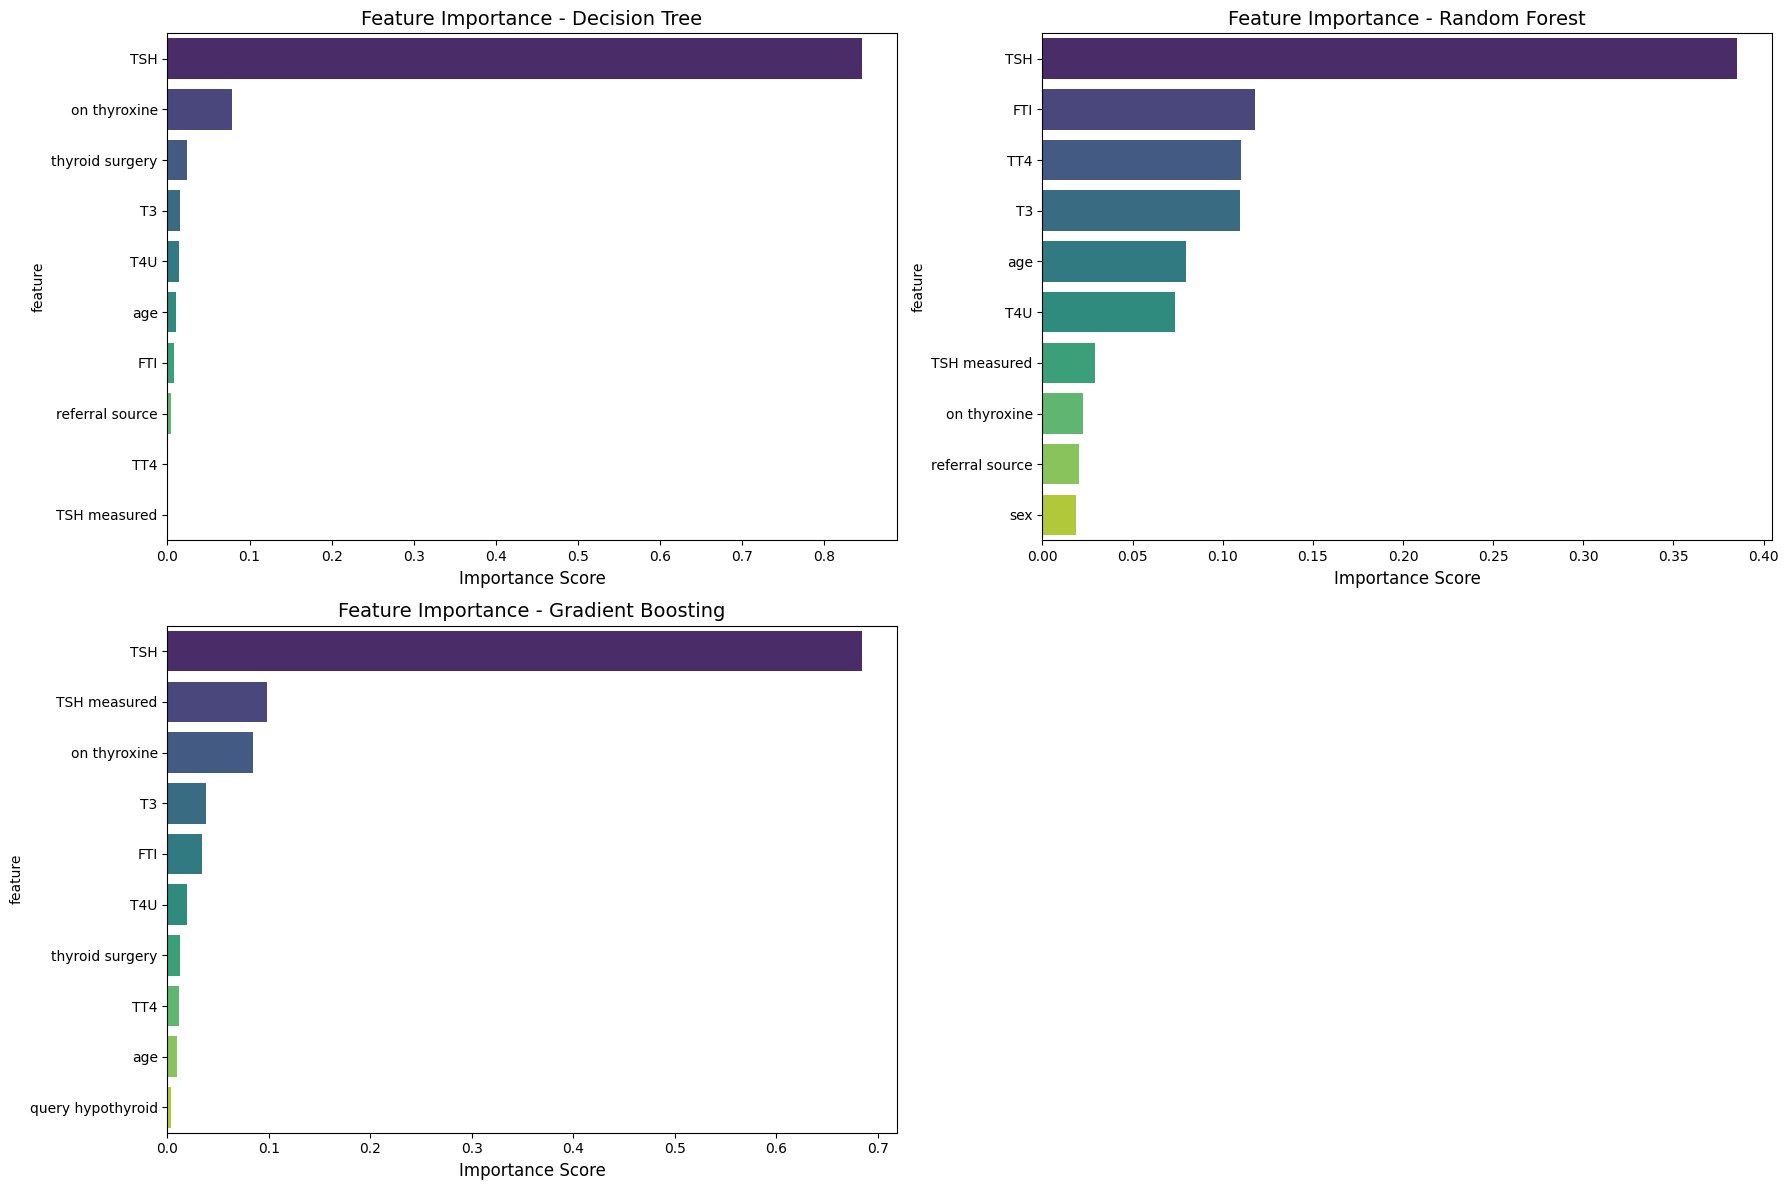

In [9]:
# Feature importance analysis for tree-based models
def analyze_feature_importance(models, feature_names):
    print("=" * 60)
    print("FEATURE IMPORTANCE ANALYSIS")
    print("=" * 60)
    
    tree_models = ['Decision Tree', 'Random Forest', 'Gradient Boosting']
    
    plt.figure(figsize=(18, 12))
    
    for i, model_name in enumerate(tree_models):
        if model_name in models:
            model = models[model_name]
            importances = model.feature_importances_
            
            # Create DataFrame for better visualization
            feature_imp_df = pd.DataFrame({
                'feature': feature_names,
                'importance': importances
            }).sort_values('importance', ascending=False)
            
            plt.subplot(2, 2, i+1)
            sns.barplot(data=feature_imp_df.head(10), x='importance', y='feature', palette='viridis')
            plt.title(f'Feature Importance - {model_name}', fontsize=14)
            plt.xlabel('Importance Score', fontsize=12)
            
            print(f"\nTop 10 features for {model_name}:")
            print(feature_imp_df.head(10))
    
    plt.tight_layout()
    plt.show()

# Analyze feature importance
analyze_feature_importance(trained_models, X_selected.columns)

KNN SPECIFIC ANALYSIS
Best KNN Parameters:
  n_neighbors: 5
  weights: distance
  metric: manhattan
  algorithm: auto

Testing different K values...
Testing different distance metrics...


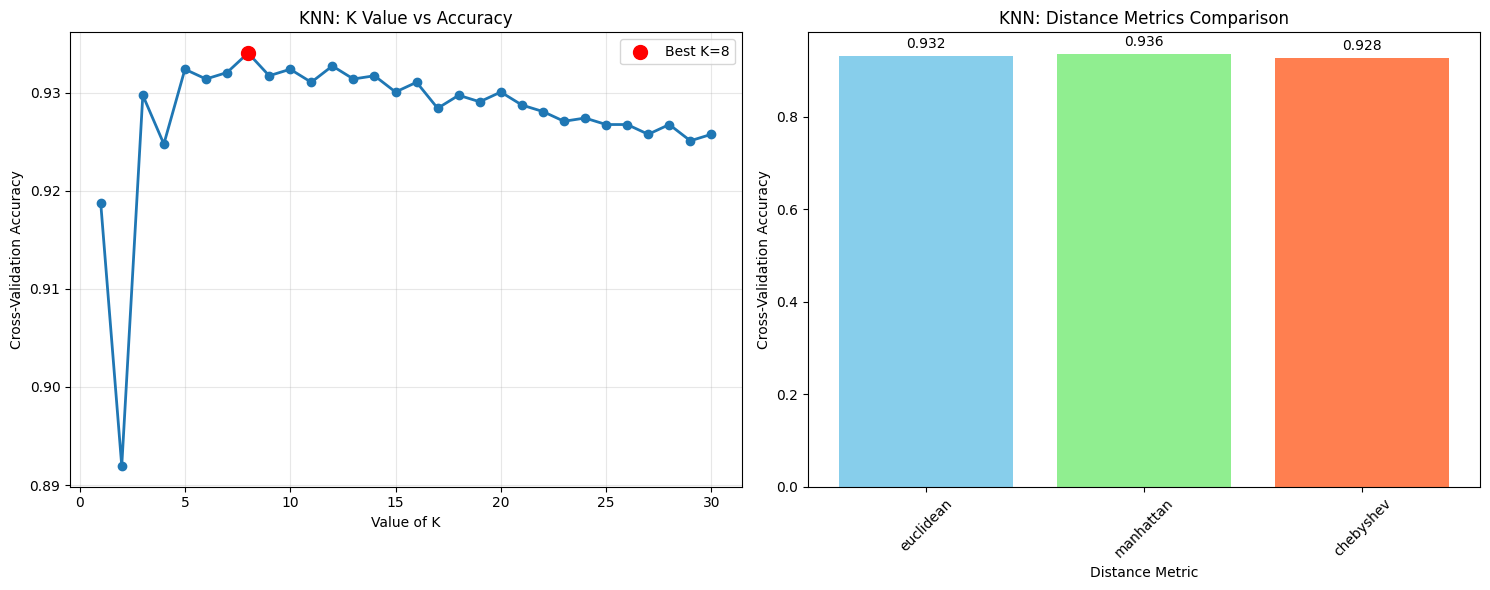


Best K value from analysis: 8
Best accuracy with K=8: 0.9340


In [10]:
# KNN specific analysis
def analyze_knn_performance(knn_model, X_train, X_test, y_train, y_test):
    print("=" * 60)
    print("KNN SPECIFIC ANALYSIS")
    print("=" * 60)
    
    # Get KNN parameters
    print(f"Best KNN Parameters:")
    print(f"  n_neighbors: {knn_model.n_neighbors}")
    print(f"  weights: {knn_model.weights}")
    print(f"  metric: {knn_model.metric}")
    print(f"  algorithm: {knn_model.algorithm}")
    
    # Test different k values for visualization
    k_range = range(1, 31)
    k_scores = []
    
    print("\nTesting different K values...")
    for k in k_range:
        knn_temp = KNeighborsClassifier(n_neighbors=k)
        scores = cross_val_score(knn_temp, X_train, y_train, cv=5, scoring='accuracy')
        k_scores.append(scores.mean())
    
    # Plot k vs accuracy
    plt.figure(figsize=(15, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(k_range, k_scores, marker='o', linewidth=2, markersize=6)
    plt.xlabel('Value of K')
    plt.ylabel('Cross-Validation Accuracy')
    plt.title('KNN: K Value vs Accuracy')
    plt.grid(True, alpha=0.3)
    
    # Highlight best k
    best_k_idx = np.argmax(k_scores)
    best_k = k_range[best_k_idx]
    plt.scatter(best_k, k_scores[best_k_idx], color='red', s=100, label=f'Best K={best_k}', zorder=5)
    plt.legend()
    
    # Distance analysis for KNN
    plt.subplot(1, 2, 2)
    distances = ['euclidean', 'manhattan', 'chebyshev']
    distance_scores = []
    
    print("Testing different distance metrics...")
    for dist in distances:
        try:
            knn_temp = KNeighborsClassifier(n_neighbors=knn_model.n_neighbors, metric=dist)
            scores = cross_val_score(knn_temp, X_train, y_train, cv=5, scoring='accuracy')
            distance_scores.append(scores.mean())
        except:
            distance_scores.append(0)
    
    bars = plt.bar(distances, distance_scores, color=['skyblue', 'lightgreen', 'coral'])
    plt.xlabel('Distance Metric')
    plt.ylabel('Cross-Validation Accuracy')
    plt.title('KNN: Distance Metrics Comparison')
    plt.xticks(rotation=45)
    
    # Add value labels on bars
    for bar, score in zip(bars, distance_scores):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{score:.3f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nBest K value from analysis: {best_k}")
    print(f"Best accuracy with K={best_k}: {max(k_scores):.4f}")

# Analyze KNN performance
if 'K-Nearest Neighbors' in trained_models:
    analyze_knn_performance(trained_models['K-Nearest Neighbors'], X_train_scaled, X_test_scaled, y_train, y_test)

ENSEMBLE MODELS
Creating Tree-based Ensemble...
Tree Ensemble Accuracy: 0.9934
Creating Complete Ensemble...
Complete Ensemble Accuracy: 0.9722


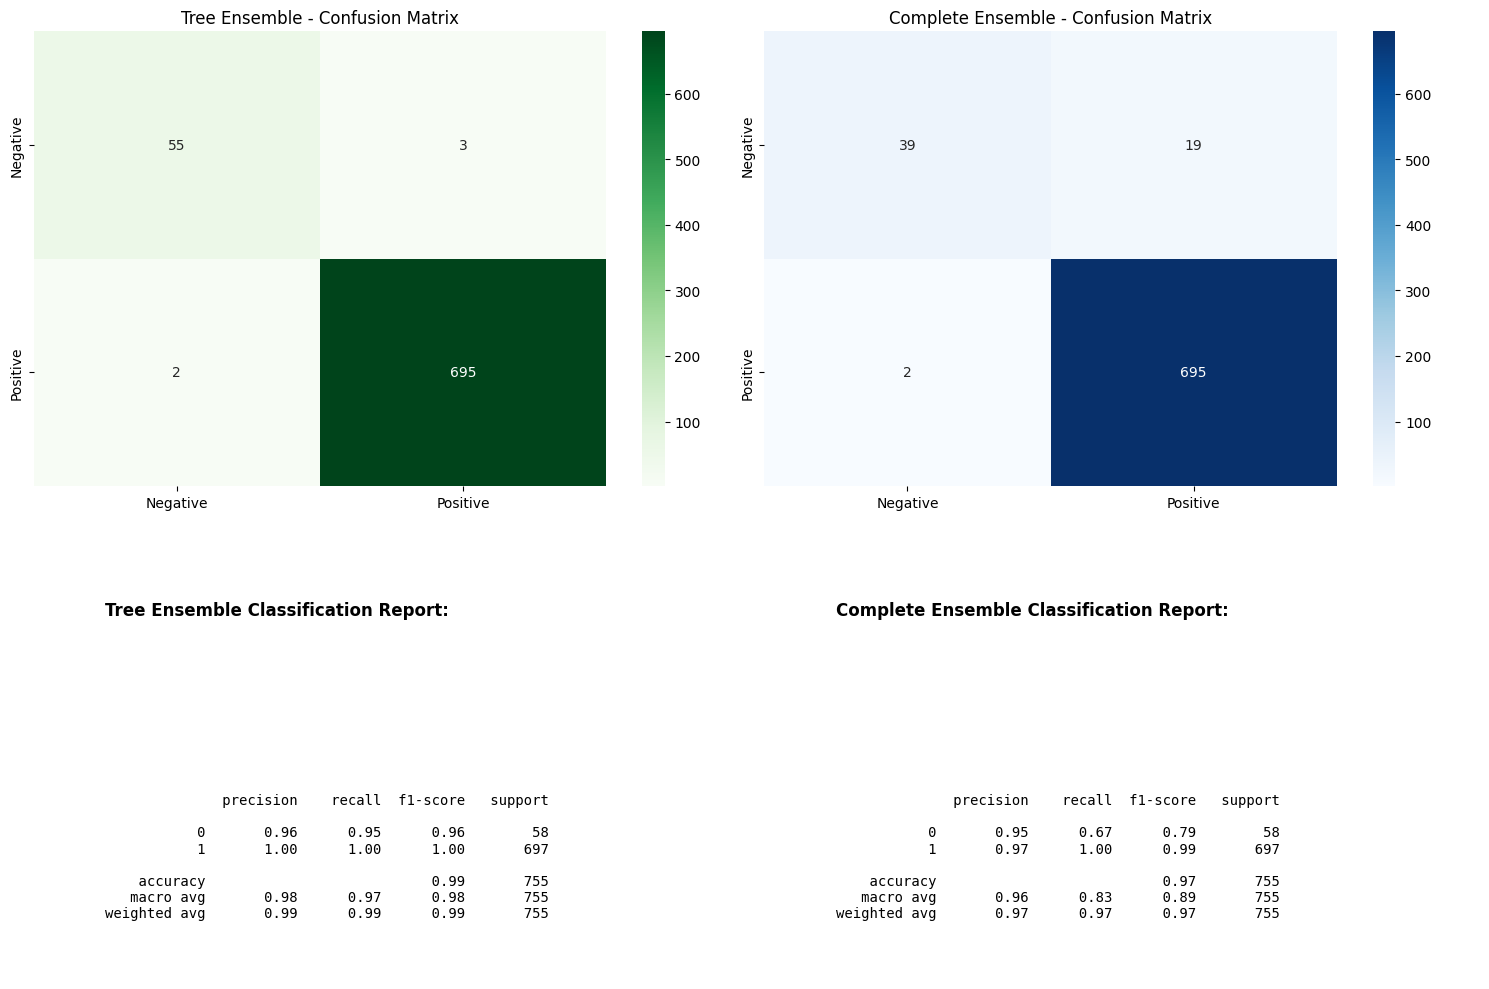

In [11]:
# Create ensemble models
def create_ensemble_models(models, X_train, X_test, y_train, y_test):
    print("=" * 60)
    print("ENSEMBLE MODELS")
    print("=" * 60)
    
    ensemble_results = {}
    
    # Ensemble 1: Tree-based models
    print("Creating Tree-based Ensemble...")
    tree_ensemble = VotingClassifier(
        estimators=[
            ('dt', models['Decision Tree']),
            ('rf', models['Random Forest']),
            ('gb', models['Gradient Boosting'])
        ],
        voting='hard'
    )
    
    tree_ensemble.fit(X_train, y_train)
    tree_pred = tree_ensemble.predict(X_test)
    tree_acc = accuracy_score(y_test, tree_pred)
    ensemble_results['Tree Ensemble'] = tree_acc
    
    print(f"Tree Ensemble Accuracy: {tree_acc:.4f}")
    
    # Ensemble 2: All models
    print("Creating Complete Ensemble...")
    complete_ensemble = VotingClassifier(
        estimators=[
            ('dt', models['Decision Tree']),
            ('rf', models['Random Forest']),
            ('knn', models['K-Nearest Neighbors']),
            ('gb', models['Gradient Boosting']),
            ('lr', models['Logistic Regression'])
        ],
        voting='hard'
    )
    
    complete_ensemble.fit(X_train, y_train)
    complete_pred = complete_ensemble.predict(X_test)
    complete_acc = accuracy_score(y_test, complete_pred)
    ensemble_results['Complete Ensemble'] = complete_acc
    
    print(f"Complete Ensemble Accuracy: {complete_acc:.4f}")
    
    # Visualization
    plt.figure(figsize=(15, 10))
    
    # Confusion matrices for ensembles
    plt.subplot(2, 2, 1)
    cm_tree = confusion_matrix(y_test, tree_pred)
    sns.heatmap(cm_tree, annot=True, fmt='d', cmap='Greens',
               xticklabels=['Negative', 'Positive'], 
               yticklabels=['Negative', 'Positive'])
    plt.title('Tree Ensemble - Confusion Matrix')
    
    plt.subplot(2, 2, 2)
    cm_complete = confusion_matrix(y_test, complete_pred)
    sns.heatmap(cm_complete, annot=True, fmt='d', cmap='Blues',
               xticklabels=['Negative', 'Positive'], 
               yticklabels=['Negative', 'Positive'])
    plt.title('Complete Ensemble - Confusion Matrix')
    
    # Classification reports
    plt.subplot(2, 2, 3)
    plt.text(0.1, 0.8, "Tree Ensemble Classification Report:", fontsize=12, weight='bold')
    plt.text(0.1, 0.1, classification_report(y_test, tree_pred), fontsize=10, family='monospace')
    plt.axis('off')
    
    plt.subplot(2, 2, 4)
    plt.text(0.1, 0.8, "Complete Ensemble Classification Report:", fontsize=12, weight='bold')
    plt.text(0.1, 0.1, classification_report(y_test, complete_pred), fontsize=10, family='monospace')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return {
        'tree_ensemble': tree_ensemble,
        'complete_ensemble': complete_ensemble,
        'results': ensemble_results
    }

# Create ensemble models
ensemble_results = create_ensemble_models(trained_models, X_train_scaled, X_test_scaled, y_train, y_test)

FINAL COMPREHENSIVE MODEL COMPARISON
Final Model Rankings by Test Accuracy:
--------------------------------------------------
 1. Gradient Boosting        : 0.9947
 2. Decision Tree            : 0.9934
 3. Tree Ensemble            : 0.9934
 4. Complete Ensemble        : 0.9722
 5. Random Forest            : 0.9656
 6. SVM                      : 0.9457
 7. Logistic Regression      : 0.9444
 8. K-Nearest Neighbors      : 0.9298


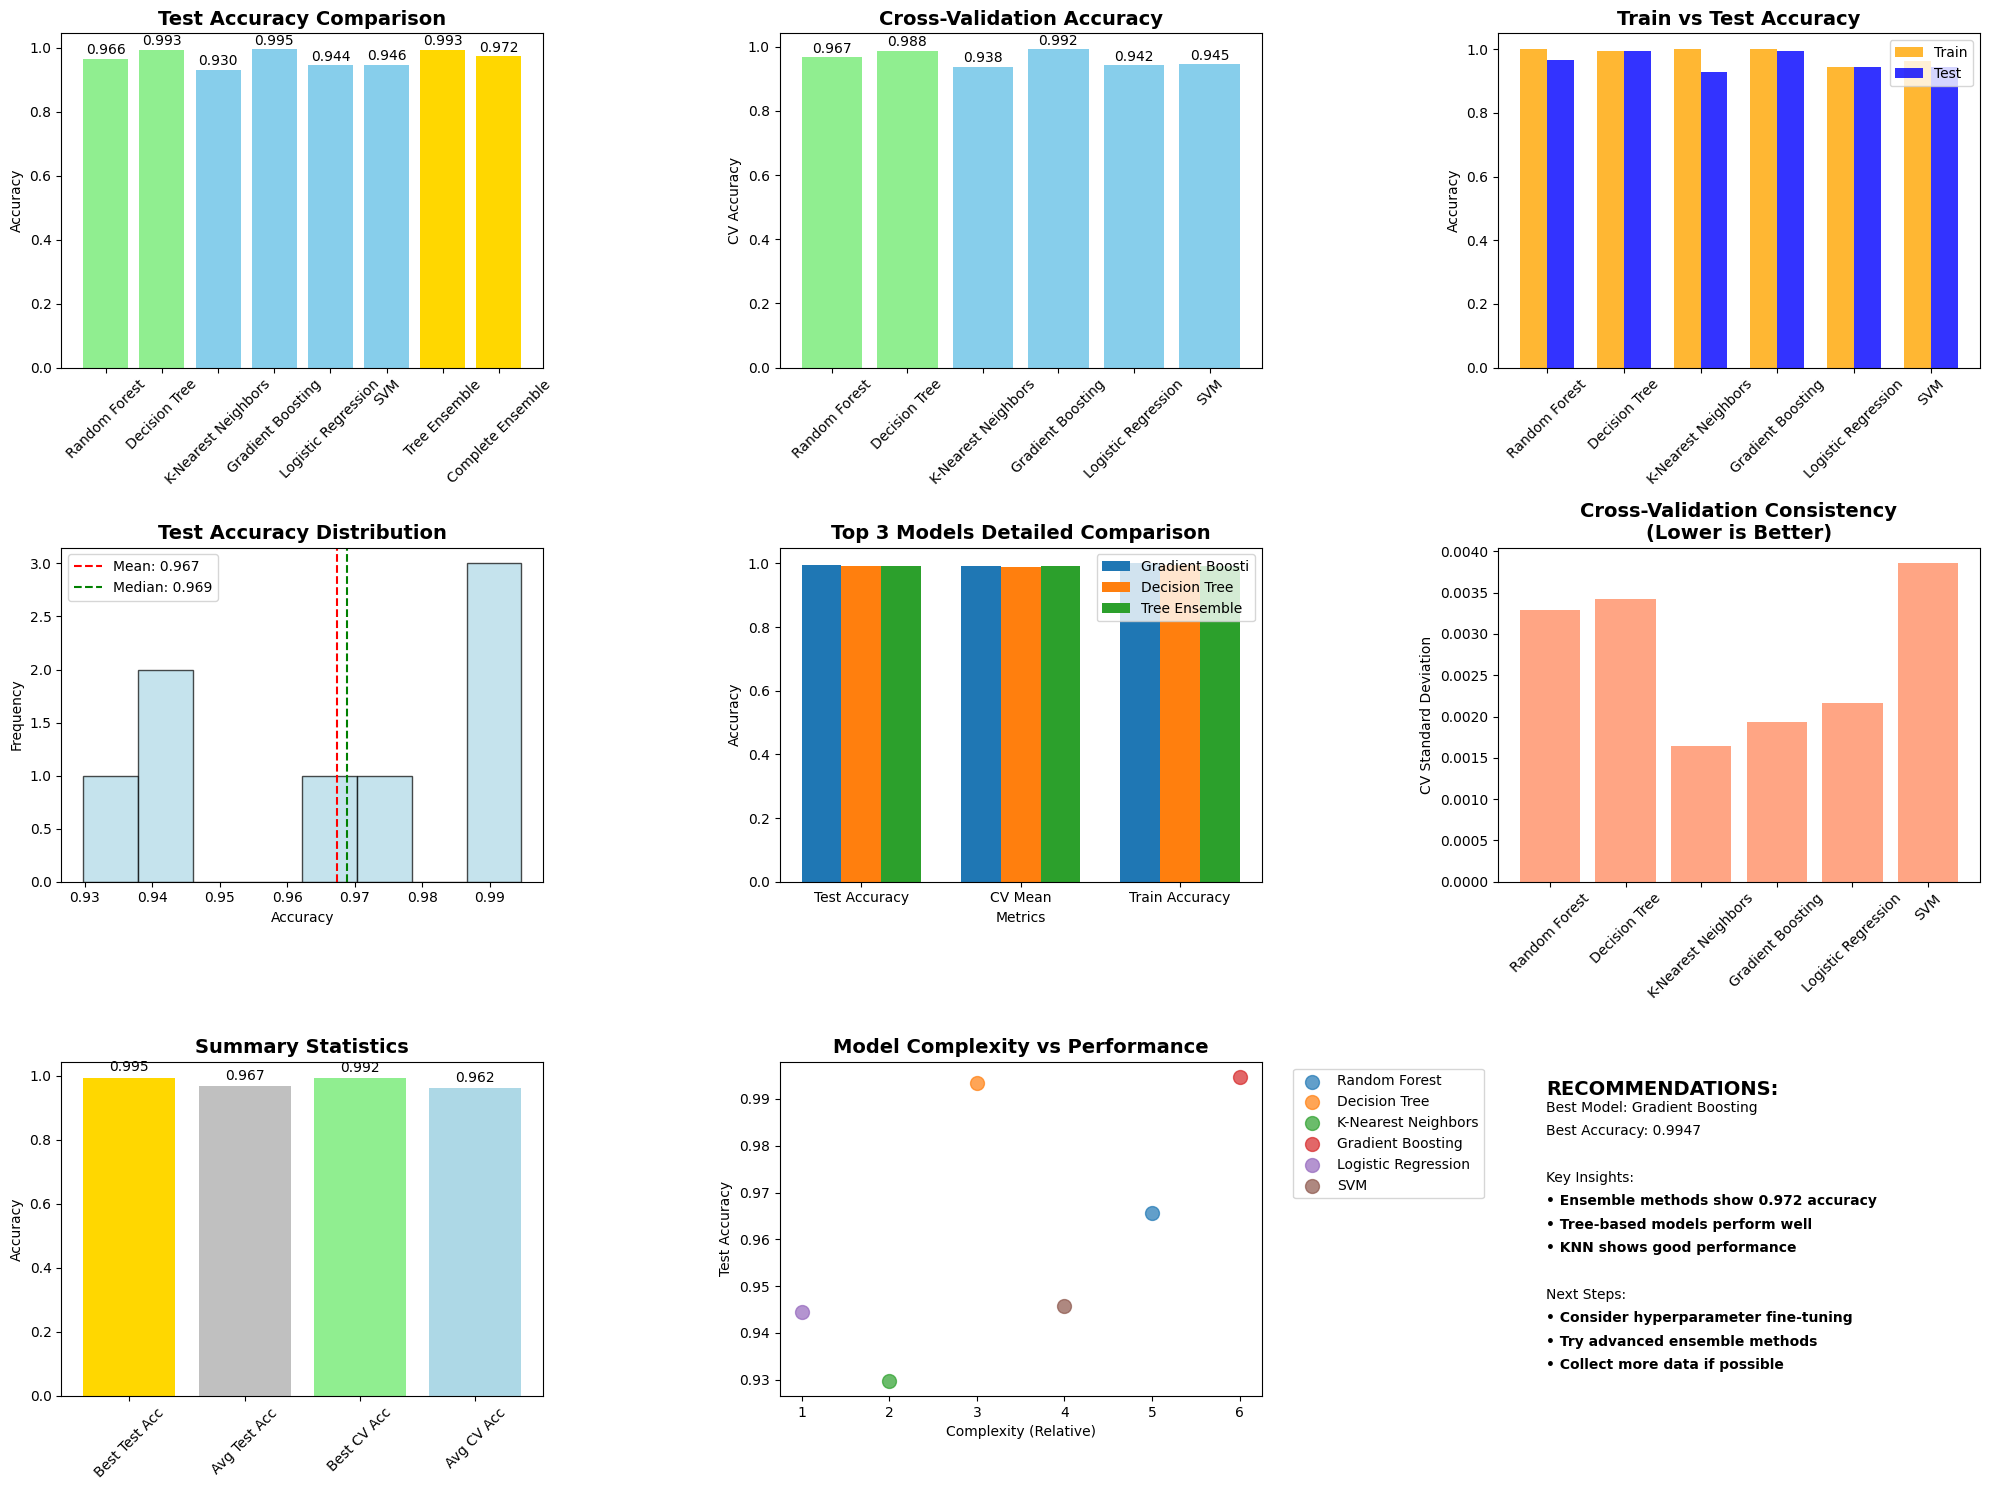

In [12]:
# Final comprehensive comparison and visualization
def final_model_comparison(results_df, ensemble_results):
    print("=" * 80)
    print("FINAL COMPREHENSIVE MODEL COMPARISON")
    print("=" * 80)
    
    # Add ensemble results to comparison
    ensemble_df = pd.DataFrame({
        'CV Mean': [np.nan, np.nan],
        'CV Std': [np.nan, np.nan],
        'Train Accuracy': [np.nan, np.nan],
        'Test Accuracy': list(ensemble_results['results'].values())
    }, index=list(ensemble_results['results'].keys()))
    
    complete_results = pd.concat([results_df, ensemble_df])
    
    # Sort by test accuracy
    sorted_results = complete_results.sort_values('Test Accuracy', ascending=False)
    
    print("Final Model Rankings by Test Accuracy:")
    print("-" * 50)
    for i, (model_name, row) in enumerate(sorted_results.iterrows(), 1):
        print(f"{i:2d}. {model_name:25s}: {row['Test Accuracy']:.4f}")
    
    # Comprehensive visualization
    plt.figure(figsize=(20, 15))
    
    # Plot 1: Test Accuracy Comparison
    plt.subplot(3, 3, 1)
    colors = ['gold' if 'Ensemble' in idx else 'lightcoral' if 'KNN' in idx 
              else 'lightgreen' if 'Tree' in idx or 'Forest' in idx 
              else 'skyblue' for idx in complete_results.index]
    bars = plt.bar(range(len(complete_results)), complete_results['Test Accuracy'], color=colors)
    plt.title('Test Accuracy Comparison', fontsize=14, weight='bold')
    plt.ylabel('Accuracy')
    plt.xticks(range(len(complete_results)), complete_results.index, rotation=45)
    
    # Add value labels on bars
    for bar, val in zip(bars, complete_results['Test Accuracy']):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, 
                f'{val:.3f}', ha='center', va='bottom', fontsize=10)
    
    # Plot 2: Cross-validation comparison (excluding ensembles)
    plt.subplot(3, 3, 2)
    cv_data = results_df['CV Mean']
    colors_cv = ['lightcoral' if 'KNN' in idx else 'lightgreen' if 'Tree' in idx or 'Forest' in idx 
                 else 'skyblue' for idx in cv_data.index]
    bars_cv = plt.bar(range(len(cv_data)), cv_data, color=colors_cv)
    plt.title('Cross-Validation Accuracy', fontsize=14, weight='bold')
    plt.ylabel('CV Accuracy')
    plt.xticks(range(len(cv_data)), cv_data.index, rotation=45)
    
    for bar, val in zip(bars_cv, cv_data):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, 
                f'{val:.3f}', ha='center', va='bottom', fontsize=10)
    
    # Plot 3: Train vs Test accuracy
    plt.subplot(3, 3, 3)
    x = range(len(results_df))
    width = 0.35
    plt.bar([i - width/2 for i in x], results_df['Train Accuracy'], width, 
            label='Train', alpha=0.8, color='orange')
    plt.bar([i + width/2 for i in x], results_df['Test Accuracy'], width, 
            label='Test', alpha=0.8, color='blue')
    plt.title('Train vs Test Accuracy', fontsize=14, weight='bold')
    plt.ylabel('Accuracy')
    plt.xticks(x, results_df.index, rotation=45)
    plt.legend()
    
    # Plot 4: Model performance distribution
    plt.subplot(3, 3, 4)
    test_scores = complete_results['Test Accuracy'].dropna()
    plt.hist(test_scores, bins=8, alpha=0.7, color='lightblue', edgecolor='black')
    plt.axvline(test_scores.mean(), color='red', linestyle='--', label=f'Mean: {test_scores.mean():.3f}')
    plt.axvline(test_scores.median(), color='green', linestyle='--', label=f'Median: {test_scores.median():.3f}')
    plt.title('Test Accuracy Distribution', fontsize=14, weight='bold')
    plt.xlabel('Accuracy')
    plt.ylabel('Frequency')
    plt.legend()
    
    # Plot 5: Top 3 models detailed comparison
    plt.subplot(3, 3, 5)
    top_3 = sorted_results.head(3)
    categories = ['Test Accuracy', 'CV Mean', 'Train Accuracy']
    
    x_pos = np.arange(len(categories))
    width = 0.25
    
    for i, (model_name, row) in enumerate(top_3.iterrows()):
        values = [row['Test Accuracy'], 
                 row['CV Mean'] if not pd.isna(row['CV Mean']) else row['Test Accuracy'],
                 row['Train Accuracy'] if not pd.isna(row['Train Accuracy']) else row['Test Accuracy']]
        plt.bar(x_pos + i*width, values, width, label=model_name[:15])
    
    plt.title('Top 3 Models Detailed Comparison', fontsize=14, weight='bold')
    plt.xlabel('Metrics')
    plt.ylabel('Accuracy')
    plt.xticks(x_pos + width, categories)
    plt.legend()
    
    # Plot 6: Performance consistency (CV std)
    plt.subplot(3, 3, 6)
    cv_std_data = results_df['CV Std'].dropna()
    plt.bar(range(len(cv_std_data)), cv_std_data, color='coral', alpha=0.7)
    plt.title('Cross-Validation Consistency\n(Lower is Better)', fontsize=14, weight='bold')
    plt.ylabel('CV Standard Deviation')
    plt.xticks(range(len(cv_std_data)), cv_std_data.index, rotation=45)
    
    # Plot 7-9: Summary statistics
    plt.subplot(3, 3, 7)
    summary_stats = {
        'Best Test Acc': complete_results['Test Accuracy'].max(),
        'Avg Test Acc': complete_results['Test Accuracy'].mean(),
        'Best CV Acc': results_df['CV Mean'].max(),
        'Avg CV Acc': results_df['CV Mean'].mean()
    }
    
    plt.bar(summary_stats.keys(), summary_stats.values(), color=['gold', 'silver', 'lightgreen', 'lightblue'])
    plt.title('Summary Statistics', fontsize=14, weight='bold')
    plt.ylabel('Accuracy')
    plt.xticks(rotation=45)
    
    for i, (key, val) in enumerate(summary_stats.items()):
        plt.text(i, val + 0.01, f'{val:.3f}', ha='center', va='bottom', fontsize=10)
    
    # Plot 8: Model complexity vs performance
    plt.subplot(3, 3, 8)
    complexity_map = {
        'Logistic Regression': 1,
        'K-Nearest Neighbors': 2,
        'Decision Tree': 3,
        'SVM': 4,
        'Random Forest': 5,
        'Gradient Boosting': 6
    }
    
    for model in results_df.index:
        if model in complexity_map:
            plt.scatter(complexity_map[model], results_df.loc[model, 'Test Accuracy'], 
                       s=100, alpha=0.7, label=model)
    
    plt.title('Model Complexity vs Performance', fontsize=14, weight='bold')
    plt.xlabel('Complexity (Relative)')
    plt.ylabel('Test Accuracy')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Plot 9: Final recommendations
    plt.subplot(3, 3, 9)
    plt.text(0.1, 0.9, "RECOMMENDATIONS:", fontsize=14, weight='bold')
    
    best_model = sorted_results.index[0]
    best_acc = sorted_results.iloc[0]['Test Accuracy']
    
    recommendations = [
        f"Best Model: {best_model}",
        f"Best Accuracy: {best_acc:.4f}",
        "",
        "Key Insights:",
        f"• Ensemble methods show {ensemble_results['results']['Complete Ensemble']:.3f} accuracy",
        f"• Tree-based models perform well",
        f"• KNN shows good performance",
        "",
        "Next Steps:",
        "• Consider hyperparameter fine-tuning",
        "• Try advanced ensemble methods",
        "• Collect more data if possible"
    ]
    
    for i, rec in enumerate(recommendations):
        plt.text(0.1, 0.85 - i*0.07, rec, fontsize=10, 
                weight='bold' if rec.startswith('•') else 'normal')
    
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return complete_results

# Final comparison
final_results = final_model_comparison(results_summary, ensemble_results)

In [13]:
# Save results and models
def save_results_and_summary():
    print("=" * 80)
    print("FINAL SUMMARY AND NEXT STEPS")
    print("=" * 80)
    
    best_individual = results_summary['Test Accuracy'].idxmax()
    best_individual_acc = results_summary['Test Accuracy'].max()
    best_ensemble_acc = max(ensemble_results['results'].values())
    best_ensemble = max(ensemble_results['results'], key=ensemble_results['results'].get)
    
    print(f"BEST INDIVIDUAL MODEL:")
    print(f"  Model: {best_individual}")
    print(f"  Test Accuracy: {best_individual_acc:.4f}")
    print(f"  Cross-validation: {results_summary.loc[best_individual, 'CV Mean']:.4f}")
    
    print(f"\nBEST ENSEMBLE MODEL:")
    print(f"  Model: {best_ensemble}")
    print(f"  Test Accuracy: {best_ensemble_acc:.4f}")
    
    print(f"\nDATASET STATISTICS:")
    print(f"  Total samples: {len(df)}")
    print(f"  Features used: {len(X_selected.columns)}")
    print(f"  Class distribution: {dict(pd.Series(y).value_counts())}")
    
    print(f"\nFEATURE IMPORTANCE (Top 5):")
    top_features = feat_importance.head(5)
    for _, row in top_features.iterrows():
        print(f"  {row['feature']}: {row['importance']:.4f}")
    
    print(f"\nNEXT STEPS FOR IMPROVEMENT:")
    improvement_suggestions = [
        "1. Hyperparameter fine-tuning with Bayesian optimization",
        "2. Feature engineering (polynomial features, interactions)",
        "3. Advanced ensemble methods (Stacking, Blending)",
        "4. Deep learning approaches",
        "5. Cross-validation with different strategies",
        "6. Handling class imbalance if present",
        "7. Data collection for more samples"
    ]
    
    for suggestion in improvement_suggestions:
        print(f"  {suggestion}")
    
    return {
        'best_individual_model': trained_models[best_individual],
        'best_ensemble_model': ensemble_results[best_ensemble.lower().replace(' ', '_')],
        'scaler': scaler,
        'feature_names': X_selected.columns.tolist(),
        'encoders': encoders,
        'target_encoder': target_encoder
    }

# Save and summarize
final_artifacts = save_results_and_summary()

print("\n" + "="*80)
print("ANALYSIS COMPLETE!")
print("All models trained, evaluated, and compared successfully.")
print("="*80)

FINAL SUMMARY AND NEXT STEPS
BEST INDIVIDUAL MODEL:
  Model: Gradient Boosting
  Test Accuracy: 0.9947
  Cross-validation: 0.9920

BEST ENSEMBLE MODEL:
  Model: Tree Ensemble
  Test Accuracy: 0.9934

DATASET STATISTICS:
  Total samples: 3772
  Features used: 15
  Class distribution: {1: np.int64(3481), 0: np.int64(291)}

FEATURE IMPORTANCE (Top 5):
  TSH: 0.3763
  FTI: 0.1152
  TT4: 0.1055
  T3: 0.1029
  age: 0.0752

NEXT STEPS FOR IMPROVEMENT:
  1. Hyperparameter fine-tuning with Bayesian optimization
  2. Feature engineering (polynomial features, interactions)
  3. Advanced ensemble methods (Stacking, Blending)
  4. Deep learning approaches
  5. Cross-validation with different strategies
  6. Handling class imbalance if present
  7. Data collection for more samples

ANALYSIS COMPLETE!
All models trained, evaluated, and compared successfully.
